In [1]:
#I used this notebook to train the baseline model with custom loss (mainly sum of stds reg loss)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import Sequence
from keras.layers import Conv2D, MaxPooling2D
from qkeras import *

from keras.utils import Sequence
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from loss import custom_loss

import os
import random

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-04-25 20:48:18.877325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 20:48:18.877407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 20:48:18.878524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 20:48:18.886328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 20:48:50.592764: W tensorflow/compiler/tf2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#from dataprep import *
from OptimizedDataGenerator import OptimizedDataGenerator
import tensorflow_probability as tfp
from models import *

2025-04-25 20:56:29.306149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 901 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 7g.40gb, pci bus id: 0000:81:00.0, compute capability: 8.0


In [4]:
batch_size = 5000
val_batch_size = 5000
train_file_size = 50  # Make this larger (150?)
val_file_size = 10

dataset_base_dir = f'/depot/cms/users/das214/dataset8/unflipped/'
tfrecords_base_dir = os.path.expanduser("~/TFrecords/")
os.makedirs(tfrecords_base_dir, exist_ok=True)

data_directory_path = os.path.join(dataset_base_dir, 'recon3D/')
labels_directory_path = os.path.join(dataset_base_dir, 'labels/')

tfrecords_dir_train = os.path.join(tfrecords_base_dir, 'TFR_train')
tfrecords_dir_validation = os.path.join(tfrecords_base_dir, 'TFR_val')

print("Nuevo directorio para train:", tfrecords_dir_train)
print("Nuevo directorio para validation:", tfrecords_dir_validation)

# validation_generator = OptimizedDataGenerator(
#      data_directory_path = data_directory_path,
#      labels_directory_path = labels_directory_path,
#      is_directory_recursive = False,
#      file_type = "parquet",
#      data_format = "3D",
#      batch_size = val_batch_size,
#      file_count = val_file_size,
#      to_standardize= True,
#      include_y_local= False, 
#      labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#      input_shape = (2,13,21), # (20,13,21),
#      transpose = (0,2,3,1),
#      shuffle = False, 
#      files_from_end=True,
#      tfrecords_dir = tfrecords_dir_validation,
#      use_time_stamps = [0, 19], #-1
#      max_workers = 1 # Don't make this too large (will use up all RAM)
#  )

# training_generator = OptimizedDataGenerator(
#      data_directory_path = data_directory_path,
#      labels_directory_path = labels_directory_path,
#      is_directory_recursive = False,
#      file_type = "parquet",
#      data_format = "3D",
#      batch_size = batch_size,
#      file_count = train_file_size,
#      to_standardize= True,
#      include_y_local= False,
#      labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#      input_shape = (2,13,21), # (20,13,21),
#      transpose = (0,2,3,1),
#      shuffle = False, # True 

#      tfrecords_dir = tfrecords_dir_train,
#      use_time_stamps = [0, 19], #-1
#      max_workers = 1 # Don't make this too large (will use up all RAM)
#  )

training_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_train,
    shuffle = True,
    seed = 13,
    quantize = True
)

validation_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_validation,
    shuffle = True,
    seed = 13,
    quantize = True
)

Nuevo directorio para train: /home/callea/TFrecords/TFR_train
Nuevo directorio para validation: /home/callea/TFrecords/TFR_val


In [5]:
print(len(os.listdir(data_directory_path)))
print(len(os.listdir(labels_directory_path)))

160
160


In [6]:
path_1 = os.listdir(data_directory_path)[0]
path_1 = os.path.join(data_directory_path, path_1)

import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_parquet(path_1)

In [7]:
x = df1.iloc[0]

data_files_path_list = os.listdir(data_directory_path)
labels_files_path_list = os.listdir(labels_directory_path)

data_df = pd.read_parquet(os.path.join(data_directory_path, data_files_path_list[0])) 
labels_df = pd.read_parquet(os.path.join(labels_directory_path, labels_files_path_list[0]))

In [8]:
len(df1)

49999

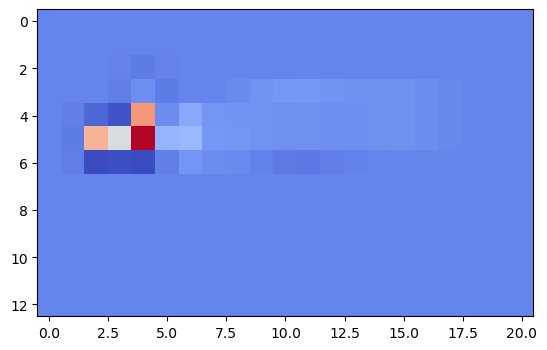

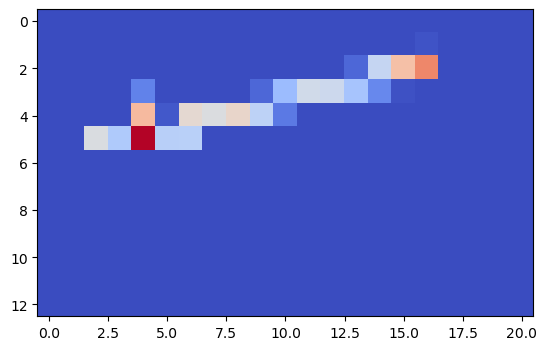

In [9]:
reshaped_data = x.values.reshape(20, 13, 21)

plt.imshow(reshaped_data[0,:,:], cmap='coolwarm') # first time-step
plt.show()
plt.imshow(reshaped_data[-1,:,:], cmap='coolwarm') # Last time-step
plt.show()

In [10]:
reshaped_data[0,:,:]

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3600e+01, -1.0760e+02,
        -1.7900e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.0800e+01

In [11]:
# compiles model
model=CreateModel((13,21,2),n_filters=5,pool_size=3)
model.summary()

2025-04-25 20:57:19.039202: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [12]:
import tensorflow_probability as tfp
from tensorflow.keras.metrics import Mean
from utils import track_loss_values

current_reg_weight = tf.Variable(0.5, trainable=False, dtype=tf.float32, name='reg_weight')

def custom_loss(y, p_base, minval=1e-9, maxval=1e9, scale = 512):

    reg_weight = current_reg_weight
    
    p = p_base
    
    mu = p[:, 0:8:2]
    
    # creating each matrix element in 4x4
    Mdia = minval + tf.math.maximum(p[:, 1:8:2], 0.0)
    Mcov = p[:,8:]
    
    # placeholder zero element
    zeros = tf.zeros_like(Mdia[:,0])
    
    # assembles scale_tril matrix
    row1 = tf.stack([Mdia[:,0],zeros,zeros,zeros])
    row2 = tf.stack([Mcov[:,0],Mdia[:,1],zeros,zeros])
    row3 = tf.stack([Mcov[:,1],Mcov[:,2],Mdia[:,2],zeros])
    row4 = tf.stack([Mcov[:,3],Mcov[:,4],Mcov[:,5],Mdia[:,3]])

    scale_tril = tf.transpose(tf.stack([row1,row2,row3,row4]),perm=[2,0,1])

    dist = tfp.distributions.MultivariateNormalTriL(loc = mu, scale_tril = scale_tril) 
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)

    cov_matrix = tf.matmul(scale_tril, tf.transpose(scale_tril, [0, 2, 1])) 
    variances = tf.linalg.diag_part(cov_matrix)
    stds = tf.sqrt(variances + minval)

    sigma_regularizer_1 = tf.reduce_sum(stds, axis=1)

    track_loss_values(NLL, reg_weight * sigma_regularizer_1)

    total_loss = NLL + (reg_weight * sigma_regularizer_1)
    
    return tf.keras.backend.sum(total_loss)

In [13]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_loss)

In [14]:
fingerprint = '%08x' % random.randrange(16**8)
os.makedirs("trained_models", exist_ok=True)
base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
os.makedirs(base_dir, exist_ok=True)  
checkpoint_filepath = base_dir + '/weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5'

In [15]:
print(fingerprint)

6603c174


In [16]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, Callback
from utils import get_loss_metrics, reset_loss_trackers
import csv

early_stopping_patience = 50

class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        checkpoints = [f for f in os.listdir(base_dir) if f.startswith('weights')]
        if len(checkpoints) > 1:
            checkpoints.sort()
            for checkpoint in checkpoints[:-1]:
                os.remove(os.path.join(base_dir, checkpoint))

class PrintSelectiveEpochLoss(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        reset_loss_trackers()
        
    def on_epoch_end(self, epoch, logs=None):
        # Obtener métricas actuales del NLL y el término de regularización ya ponderado
        metrics = get_loss_metrics()
        
        nll = metrics['nll']
        reg = metrics['reg_term'] 
        total = nll + reg

        print(f"🔁 Epoch {epoch + 1} - NLL: {nll:.4f} | Reg (weighted): {reg:.4f} | Total approx: {total:.4f}")

# Linear scheduler
class LinearScheduler(Callback):
    def __init__(
        self,
        start=0.5,            # Initial regularization weight λ
        end=5.0,              # Maximum λ to reach
        max_epochs=500,       # Number of epochs over which λ will increase linearly
        stop_threshold=-25000 # Validation loss threshold beyond which λ stops increasing
    ):
        super().__init__()
        self.start = start
        self.end = end
        self.max_epochs = max_epochs
        self.stop_thresh = stop_threshold

    def on_train_begin(self, logs=None):
        # Set the initial λ value
        current_reg_weight.assign(self.start)
        print(f"reg_weight initialized to {self.start:.4f}")

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        if val_loss is None:
            return  # If validation loss is not available, do nothing

        if val_loss > self.stop_thresh:
            # If val loss is still above the threshold, increase λ linearly based on the current epoch
            α = min((epoch + 1) / self.max_epochs, 1.0)
            new_w = self.start + α * (self.end - self.start)
            current_reg_weight.assign(new_w)
            print(f"[Epoch {epoch+1}] val_loss={val_loss:.1f} > {self.stop_thresh} → reg_weight={new_w:.4f}")
        else:
            # If val loss is below or equal to the threshold, freeze λ at its current value
            print(f"[Epoch {epoch+1}] val_loss={val_loss:.1f} ≤ {self.stop_thresh} → reg_weight frozen at {current_reg_weight.numpy():.4f}")

class EpochLossLogger(tf.keras.callbacks.Callback):
    def __init__(self, fingerprint, base_dir = './trained_models'):
        super().__init__()
        self.fingerprint = fingerprint
        self.dir = os.path.join(base_dir, f"model-{fingerprint}-checkpoints")
        os.makedirs(self.dir, exist_ok=True)  # Crea la carpeta si no existe

        self.log_file = os.path.join(self.dir, 'loss_tracking.csv')
        if not os.path.exists(self.log_file):
            with open(self.log_file, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['epoch', 'train_loss', 'val_loss', 'NLL', 'reg', 'total', 'reg_weight'])

    def on_epoch_end(self, epoch, logs=None):
        metrics = get_loss_metrics()
        nll = float(metrics['nll'])
        reg = float(metrics['reg_term'])
        total = nll + reg
        reg_weight = float(current_reg_weight.numpy())
        train_loss = logs.get('loss', None)
        val_loss = logs.get('val_loss', None)

        with open(self.log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, train_loss, val_loss, nll, reg, total, reg_weight])


es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

print_epoch_loss = PrintSelectiveEpochLoss()

linear_cb = LinearScheduler(
    start=0.5,
    end=5.0,
    max_epochs=500,
    stop_threshold=-25000
)

loss_logger = EpochLossLogger(fingerprint=fingerprint, base_dir=base_dir)

csv_logger = CSVLogger(f'{base_dir}/training_log.csv', append=True)

In [17]:
history = model.fit(
        x=training_generator,
        validation_data=validation_generator,
        callbacks=[mcp, csv_logger, print_epoch_loss, linear_cb, loss_logger],
        epochs=500,
        shuffle=False,
        steps_per_epoch=len(training_generator),
        validation_steps=len(validation_generator),
        verbose=1
    )

🔧 reg_weight initialized to 0.5000
Epoch 1/500


2025-04-25 20:57:28.887823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-25 20:57:30.747729: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-25 20:57:32.363125: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x561bfe065320
2025-04-25 20:57:35.168424: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f03ecb9e8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-25 20:57:35.168483: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 7g.40gb, Compute Capability 8.0
2025-04-25 20:57:36.750745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745607459.038433   36731 device_compiler.h:186] Compile

499/499 [==============================] - ETA: 0s - loss: 11925.9697
Epoch 1: val_loss improved from inf to -4004.95410, saving model to ./trained_models/model-6603c174-checkpoints/weights.01-t11925.97-v-4004.95.hdf5
🔁 Epoch 1 - NLL: 1.2650 | Reg (weighted): 0.5966 | Total approx: 1.8616
[Epoch 1] val_loss=-4005.0 > -25000 → reg_weight=0.5030
499/499 [==============================] - 89s 143ms/step - loss: 11925.9697 - val_loss: -4004.9541
Epoch 2/500
499/499 [==============================] - ETA: 0s - loss: -3880.7922
Epoch 2: val_loss improved from -4004.95410 to -7096.83301, saving model to ./trained_models/model-6603c174-checkpoints/weights.02-t-3880.79-v-7096.83.hdf5
🔁 Epoch 2 - NLL: -1.2734 | Reg (weighted): 0.3884 | Total approx: -0.8851
[Epoch 2] val_loss=-7096.8 > -25000 → reg_weight=0.5080
499/499 [==============================] - 44s 88ms/step - loss: -3880.7922 - val_loss: -7096.8330
Epoch 3/500
499/499 [==============================] - ETA: 0s - loss: -8577.8545
Epoch

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



499/499 [==============================] - ETA: 0s - loss: -9568.4531
Epoch 499: val_loss did not improve from -18086.20117
🔁 Epoch 499 - NLL: -4.4405 | Reg (weighted): 2.5713 | Total approx: -1.8692
[Epoch 499] val_loss=-8050.2 > -25000 → reg_weight=9.6607
499/499 [==============================] - 43s 87ms/step - loss: -9568.4531 - val_loss: -8050.1763
Epoch 500/500
499/499 [==============================] - ETA: 0s - loss: -9569.1494
Epoch 500: val_loss did not improve from -18086.20117
🔁 Epoch 500 - NLL: -4.4690 | Reg (weighted): 2.5604 | Total approx: -1.9086
[Epoch 500] val_loss=-9232.1 > -25000 → reg_weight=9.6674
499/499 [==============================] - 43s 86ms/step - loss: -9569.1494 - val_loss: -9232.1357
